# dataset и исходный JNotebook взяла здесь 
https://www.kaggle.com/chromerai/sentiment-analysis-rnn

In [300]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [301]:
import matplotlib.pyplot as plt
import tensorflow as tf

from  tensorflow.keras.preprocessing.text import Tokenizer
from  tensorflow.keras.preprocessing.sequence import pad_sequences

In [302]:
train_data = pd.read_csv('train.tsv.zip', sep = '\t')
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [303]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [304]:
train_data.shape

(156060, 4)

# Загружаю тестовые данные свои

In [305]:
test_data=pd.read_csv("test.csv")
test_data.head()
test_data = test_data.rename(columns={'email_body': 'Phrase', "id":"SentenceId"})
test_data["PhraseId"]=test_data["SentenceId"]

In [306]:
test_data.head()

,SentenceId,Phrase,PhraseId
0,0,"Hi Don,\n\n \n\n4pm does not work unfortunatel...",0
1,1,"Sorry, Greg. I’ve been buried this week. I’m d...",1
2,2,"Hey Paul,\n\n \n\nThanks for the time on the c...",2
3,3,"Hi,\n\n \n\nIncluding one of my Admins who wor...",3
4,4,"Hello Momin,\n\n \n\nTo follow up on our last ...",4


In [307]:
print(test_data.shape)
test_data.info()

(100, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SentenceId  100 non-null    int64 
 1   Phrase      100 non-null    object
 2   PhraseId    100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [308]:
train_data.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

## Imbalanced dataset
### делаю oversampling

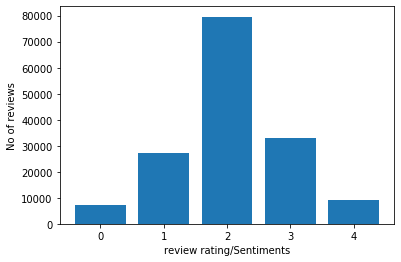

In [309]:
val_array = train_data['Sentiment'].value_counts()
plt.bar(val_array.index, val_array)
plt.xlabel('review rating/Sentiments')
plt.ylabel('No of reviews')
plt.show()

In [310]:
count_class_0, count_class_1,count_class_2, count_class_3, count_class_4  = train_data.Sentiment.value_counts()

# Divide by class
df_class_0 = train_data[train_data['Sentiment'] == 0]
df_class_1 = train_data[train_data['Sentiment'] == 1]
df_class_2 = train_data[train_data['Sentiment'] == 2]
df_class_3 = train_data[train_data['Sentiment'] == 3]
df_class_4 = train_data[train_data['Sentiment'] == 4]


df_class_0_under = df_class_0.sample(count_class_0, replace=True)
df_class_1_under = df_class_1.sample(count_class_0, replace=True)
df_class_4_under = df_class_4.sample(count_class_0, replace=True)
df_class_3_under = df_class_3.sample(count_class_0, replace=True)

train_data = pd.concat([df_class_0_under,df_class_1_under,df_class_4_under, df_class_3_under, df_class_2], axis=0)

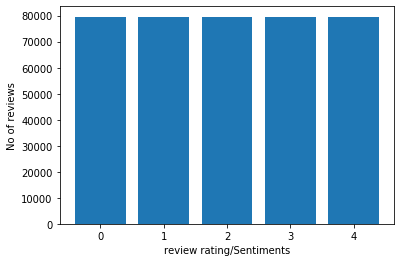

In [311]:
val_array = train_data['Sentiment'].value_counts()
plt.bar(val_array.index, val_array)
plt.xlabel('review rating/Sentiments')
plt.ylabel('No of reviews')
plt.show()

## Preprocessing осталвяю без изменений

In [182]:
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re

In [183]:
def clean_sentences(df):
    
    reviews = []
    for sent in tqdm(df['Phrase']):
        # removing non-alphabetical characters 
        text = re.sub("[^a-zA-Z]"," ",sent)
        
        # Now tokenizing the sentence : 
        words = word_tokenize(text.lower())
        
        #removing stop words :
        new_words = [ ele for ele in words if ele.lower() not in stopwords.words('english') ]
        
        # Lemmatizing each word to its lemma
        lem = WordNetLemmatizer()
        lem_words = [lem.lemmatize(i) for i in new_words]
        
        #finally
        reviews.append(lem_words)
        
    return(reviews)


In [184]:
%%time
train_sentences = clean_sentences(train_data)
test_sentences = clean_sentences(test_data)

print(len(train_sentences))
print(len(test_sentences))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 129.32it/s]

397910
100
Wall time: 14min 38s


In [185]:
train_sentences

[['crap', 'like'],
 ['water', 'turning', 'grit', 'vulnerability', 'light', 'reading'],
 ['dead', 'end', 'distaste'],
 ['superfluous',
  'sequel',
  'plagued',
  'old',
  'familiar',
  'feeling',
  'let',
  'get',
  'thing',
  'everyone',
  'shown',
  'appointed',
  'time',
  'place'],
 ['confused', 'death', 'smoochy', 'something', 'ugly', 'mindless'],
 ['drama',
  'waiting',
  'hear',
  'john',
  'malkovich',
  'reedy',
  'consigliere',
  'pronounce',
  'next',
  'line'],
 ['faced',
  'possibility',
  'life',
  'meaningless',
  'vapid',
  'devoid',
  'substance',
  'movie',
  'definitely',
  'meaningless',
  'vapid',
  'devoid',
  'substance'],
 ['time', 'low', 'kevin', 'costner'],
 ['movie',
  'bad',
  'quickly',
  'enters',
  'pantheon',
  'wreckage',
  'includes',
  'battlefield',
  'earth',
  'showgirl'],
 ['trash'],
 ['emerges', 'simple', 'fact', 'movie', 'virtually', 'nothing', 'show'],
 ['work', 'word', 'radical', 'suck'],
 ['start', 'bad', 'feel', 'like', 'running', 'screaming'

In [187]:
from tensorflow.keras.utils import to_categorical

y_target = to_categorical(train_data['Sentiment'].values)


In [ ]:
y_target

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

Set Training & Validation set to 80/20

In [188]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(train_sentences,y_target,test_size = 0.2,stratify = y_target)

In [ ]:
X_train[0]

In [189]:
unique_words = set()
len_max = -1

for sent in tqdm(X_train):
    unique_words.update(sent)
    if(len_max < len(sent)):
        len_max = len(sent)

print('Words in vocab : ' , len(list(unique_words)))
print('Max_length : ' , len_max)

100%|██████████████████████████████████████████████████████████████████████| 318328/318328 [00:00<00:00, 637545.52it/s]

Words in vocab :  13614
Max_length :  30


Now tokenizing the data set :

In [190]:
vocab_size = len(list(unique_words))
embedding_dim = 300
max_length = len_max
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [191]:
%%time
tokenizer = Tokenizer(num_words = vocab_size,
                      # filters = '#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      oov_token = oov_tok,
                      # lower = True,
                      char_level = False)

tokenizer.fit_on_texts(list(X_train))

# Training
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,
                        maxlen = max_length,
                        padding = padding_type,
                        truncating = trunc_type)

# Validation
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,
                      maxlen = max_length,
                      padding = padding_type,
                      truncating = trunc_type)

# Testing
X_test = tokenizer.texts_to_sequences(test_sentences)
X_test = pad_sequences(X_test,
                       maxlen = max_length,
                       padding = padding_type,
                       truncating = trunc_type)

Wall time: 5.38 s


In [192]:
print("X_training shape   : ",X_train.shape)
print("X_validation shape : ",X_val.shape)
print("X_testing shape    : ",X_test.shape)

X_training shape   :  (318328, 30)
X_validation shape :  (79582, 30)
X_testing shape    :  (100, 30)


In [193]:
X_train

array([[    9,    46,   324, ...,     0,     0,     0],
       [  715,   732,    36, ...,     0,     0,     0],
       [  192,     0,     0, ...,     0,     0,     0],
       ...,
       [ 2694,  3389, 10589, ...,     0,     0,     0],
       [ 7242,   110,   239, ...,     0,     0,     0],
       [   72,     0,     0, ...,     0,     0,     0]])

In [194]:
print(X_train[2])

[192   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [195]:
from  tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Dense,Bidirectional,LSTM,Activation,Conv1D,MaxPool1D,Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam

## Фиксирую random.state 
# вовремя этого не сделала

In [272]:
# Apparently you may use different seed values at each stage
seed_value= 12345

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow
tensorflow.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tensorflow.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tensorflow.compat.v1.Session(graph=tensorflow.compat.v1.get_default_graph(), config=session_conf)
#K.session(sess)
tensorflow.compat.v1.keras.backend.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

# Модель

## 1. Вариант переобучался

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size,embedding_dim,input_length = max_length))
# model.add(Bidirectional(LSTM(128,dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True)))
# model.add(Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences=False)))
# model.add(Dense(128,activation = 'relu'))
# model.add(Dense(y_target.shape[1],activation = 'softmax'))

# model.compile(loss = 'categorical_crossentropy',
#              optimizer = 'adam',
#              metrics = ['accuracy'])

# model.summary()

## 2. Вариант показывал хороший perfomance на validation_set, но плохой на test

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size,embedding_dim,input_length = max_length))
# model.add(LSTM(128,dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True))
# model.add(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences=False))
# model.add(Dense(128,activation = 'relu'))
# model.add(Dense(y_target.shape[1],activation = 'softmax'))

# model.compile(loss = 'categorical_crossentropy',
#              optimizer = 'adam',
#              metrics = ['accuracy'])

# model.summary()

## 3. Упрастила модель

In [295]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_length = max_length))
model.add(LSTM(256))
model.add(Dense(y_target.shape[1],activation = 'sigmoid')) # изменила 'softmax' на 'sigmoid'

opt = Adam(lr=0.0005)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 30, 300)           4084200   
_________________________________________________________________
lstm_27 (LSTM)               (None, 256)               570368    
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 1285      
Total params: 4,655,853
Trainable params: 4,655,853
Non-trainable params: 0
_________________________________________________________________


In [224]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta = 0.001,
                               mode = 'max',
                               monitor = 'val_acc',
                               patience = 2)
callback = [early_stopping]

In [296]:
%%time

num_epochs = 2

history = model.fit(X_train,y_train,
                    validation_data = (X_val, y_val),
                    epochs = num_epochs,
                    batch_size = 256,
                    verbose = 1,
                    callbacks = callback)

Train on 318328 samples, validate on 79582 samples
Epoch 1/2
318328/318328 [==============================] - 159s 500us/sample - loss: 1.0551 - accuracy: 0.5504 - val_loss: 0.8229 - val_accuracy: 0.6664
Epoch 2/2
318328/318328 [==============================] - 160s 501us/sample - loss: 0.7646 - accuracy: 0.6950 - val_loss: 0.7343 - val_accuracy: 0.7081
Wall time: 5min 18s


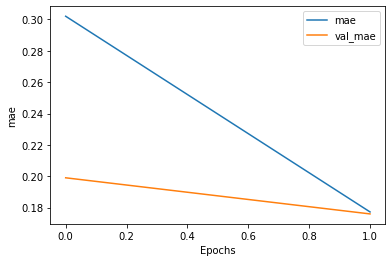

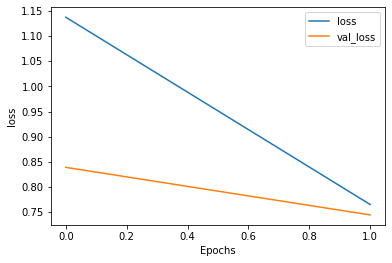

In [238]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, 'mae')
plot_graphs(history, 'loss')

In [297]:
test_id = test_data['PhraseId']
y_pred = np.argmax(model.predict(X_test), axis = -1)

submission_df = pd.DataFrame({'id': test_id, 'sentiment': y_pred})
submission_df["sentiment"]=submission_df["sentiment"]+1
submission_df.to_csv('submission.csv', index=False)
